In [14]:
import numpy as np
import scipy as sp
import scipy.io as io
from sklearn.model_selection import train_test_split
from os import path as path
import matplotlib.pyplot as plt
from math import floor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input
from tensorflow.keras.utils import to_categorical
import qkeras as qkeras
from qkeras import *

In [15]:
### Loading Data ###
xmat = io.loadmat('xdata_64.mat')
ymat = io.loadmat('ydata_64.mat')
xs = xmat['x_data']
ys = ymat['y_data']

In [16]:
### Include "multi-unit"  ###
include_multiunit = 1 
units = 20 # number of non-multiunit classes
samps = xs.shape[0]
i = 0
while i < xs.shape[0]:
    if ys[i] == 0 and not include_multiunit:
        ys = np.delete(ys, i, 0)
        xs = np.delete(xs, i, 0)
        continue
    if ys[i][0] > units:
        ys = np.delete(ys, i, 0)
        xs = np.delete(xs, i, 0)
        continue
    i += 1

In [17]:
if not include_multiunit:
    for i in range(ys.shape[0]):
        ys[i] -= 1

In [18]:
#### Functions for Data manipulation ###
def shift(x):
    return x + abs(np.amin(x))

def rand_roll_sig(x, min_roll, max_roll):
    roll_amt = np.random.randint(min_roll, max_roll+1)
    return np.roll(x, roll_amt)

def quantize_signal(x, nbits, quant_range):
    y = np.empty_like(x)
    dv = (quant_range[1]-quant_range[0])/(2**nbits)
    for i in range(x.shape[0]):
        if x[i] < quant_range[0]:
            y[i] = quant_range[0]
        elif x[i] > quant_range[1]:
            y[i] = quant_range[1]
        else:
            y[i] = x[i]
        y[i] = min(floor(y[i]/dv)*dv, (2**nbits -1) * dv)
    return y    

def add_noise(orig_sig, desired_SNR_dB):
    # Desired SNR in dB
    SNR_dB = desired_SNR_dB
    # Desired linear SNR
    snr = 10.0**(SNR_dB/10.0)
    p1 = orig_sig.var()

    # Calculate required noise power for desired SNR
    n = p1/snr

    # Generate noise with calculated power
    w = np.sqrt(n)*sp.randn(orig_sig.shape[0])

    # Add noise to signal
    return orig_sig + w

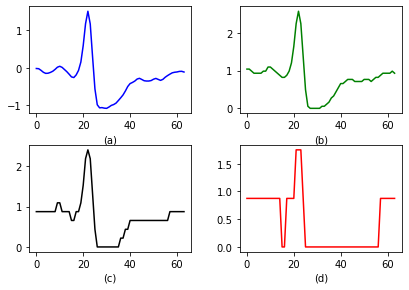

In [19]:
fig, ax = plt.subplots(2, 2)
fig.tight_layout()

# ax.yaxis.set_visible(False) # same for y axis.


orig = xs[0]
res_6 = quantize_signal(shift(xs[0]), 6, [0, 3.5])
res_4 = quantize_signal(shift(xs[0]), 4, [0, 3.5])
res_2 = quantize_signal(shift(xs[0]), 2, [0, 3.5])

ax[0, 0].plot(xs[0], 'b') #row=0, col=0
ax[0, 0].set_xlabel("(a)")
# ax[0, 0].yaxis.set_visible(False)

ax[0, 1].plot(res_6, 'g') #row=0, col=1
ax[0, 1].set_xlabel("(b)")
# ax[0, 1].yaxis.set_visible(False)

ax[1, 0].plot(res_4, 'k') #row=1, col=0
ax[1, 0].set_xlabel("(c)")
# ax[1, 0].yaxis.set_visible(False)

ax[1, 1].plot(res_2, 'r') #row=1, col=1
ax[1, 1].set_xlabel("(d)")
# ax[1, 1].yaxis.set_visible(False)

plt.show()

In [20]:
xs_q_n = np.empty_like(xs)
for i in range(xs.shape[0]):
    sig = xs[i]
    
    sig = shift(sig)
    sig = quantize_signal(sig, nbits=10, quant_range=[0,3.5])
    xs_q_n[i] = sig

# Split data

In [21]:
### Split Data ###
all_classes = len(np.unique(ys))


train_ratio = 0.75
validation_ratio = 0.1
test_ratio = 0.15

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(xs_q_n, ys, test_size=1 - train_ratio, random_state=2021)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=2021)

x_train_reshaped = np.expand_dims(x_train, axis=2)
x_test_reshaped = np.expand_dims(x_test, axis=2)
x_val_reshaped = np.expand_dims(x_val, axis=2)

print(x_train_reshaped.shape, y_train.shape, x_val_reshaped.shape, y_val.shape, x_test_reshaped.shape, y_test.shape)

(11361, 64, 1) (11361, 1) (1515, 64, 1) (1515, 1) (2273, 64, 1) (2273, 1)


# Define model

# Model Function

In [22]:
### TensorFlow Model ###
def create_model(all_classes, inp_shape):
    model = Sequential()
    model.add(Conv1D(filters=4, kernel_size=5, activation='relu', input_shape=inp_shape))
    model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

    model.add(MaxPooling1D(pool_size=3))

    model.add(Flatten())
    model.add(Dense(all_classes, activation='softmax'))


    return model

In [23]:
### compile and training ###
model = create_model(all_classes, x_train_reshaped[0].shape)

In [24]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=keras.optimizers.Adam(lr=0.001),
  metrics=['accuracy'],
)

model_file_name = './model/synthetic_full.wts.h5'


# Train the model.
model.fit(
  x_train_reshaped,
  to_categorical(y_train),
  epochs=60,
  batch_size=32,
  validation_data=(x_val_reshaped, to_categorical(y_val)),
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                    keras.callbacks.ModelCheckpoint(model_file_name, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')]
)

model.load_weights(model_file_name)

predicted_unit = model.predict(x_test_reshaped) # FINAL FUNCTION CALL

acc = model.evaluate(x_test_reshaped, to_categorical(y_test))[1]
print(acc)

Epoch 1/60
356/356 [==============================] - 0s 1ms/step - loss: 2.5723 - accuracy: 0.2740 - val_loss: 1.9004 - val_accuracy: 0.4653
Epoch 2/60
356/356 [==============================] - 0s 912us/step - loss: 1.1982 - accuracy: 0.6551 - val_loss: 0.7617 - val_accuracy: 0.7934
Epoch 3/60
356/356 [==============================] - 0s 877us/step - loss: 0.5353 - accuracy: 0.8436 - val_loss: 0.4223 - val_accuracy: 0.8739
Epoch 4/60
356/356 [==============================] - 0s 893us/step - loss: 0.3184 - accuracy: 0.9087 - val_loss: 0.2809 - val_accuracy: 0.9076
Epoch 5/60
356/356 [==============================] - 0s 937us/step - loss: 0.2207 - accuracy: 0.9368 - val_loss: 0.2035 - val_accuracy: 0.9373
Epoch 6/60
356/356 [==============================] - 0s 911us/step - loss: 0.1680 - accuracy: 0.9508 - val_loss: 0.1670 - val_accuracy: 0.9406
Epoch 7/60
356/356 [==============================] - 0s 908us/step - loss: 0.1372 - accuracy: 0.9585 - val_loss: 0.1343 - val_accuracy: 0

In [25]:
### qKeras Model ###
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)

    x = QConv1D(4, 5,
        kernel_quantizer="quantized_po2(12)", 
        bias_quantizer="quantized_po2(8)",
        name="conv1d_1")(x)
    x = QActivation("quantized_relu(12)", name="act_1")(x)
    
    x = QConv1D(1, 3,
        kernel_quantizer="quantized_po2(12)", 
        bias_quantizer="quantized_po2(8)",
        name="conv1d_2")(x)
    x = QActivation("quantized_relu(12)", name="act_2")(x)    

    x = MaxPooling1D(3)(x)
    x = Flatten(name="flatten")(x)
    x = QDense(nb_classes,
        kernel_quantizer="quantized_po2(4,4,1)",
        bias_quantizer="quantized_po2(4,4,1)",
        name="dense")(x)
    x = Activation("softmax", name="softmax")(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    return model

In [26]:
### compile and training ###
qmodel2 = CreateQModel(x_train_reshaped[0].shape, len(np.unique(y_train)))


In [27]:
qmodel2.compile(
  loss='categorical_crossentropy',
  optimizer=keras.optimizers.Adam(lr=0.001),
  metrics=['accuracy'],
)

model_file_name_q = './model/synthetic_q.wts.h5'


# Train the model.
qmodel2.fit(
  x_train_reshaped,
  to_categorical(y_train),
  epochs=200,
  batch_size=32,
  validation_data=(x_val_reshaped, to_categorical(y_val)),
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
                    keras.callbacks.ModelCheckpoint(model_file_name_q, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')]
)

qmodel2.load_weights(model_file_name_q)

predicted_unit = qmodel2.predict(x_test_reshaped) # FINAL FUNCTION CALL

acc = qmodel2.evaluate(x_test_reshaped, to_categorical(y_test))[1]
print(acc)

Epoch 1/200
356/356 [==============================] - 1s 2ms/step - loss: 2.7787 - accuracy: 0.1700 - val_loss: 2.4258 - val_accuracy: 0.3135
Epoch 2/200
356/356 [==============================] - 0s 1ms/step - loss: 2.1770 - accuracy: 0.3745 - val_loss: 1.9359 - val_accuracy: 0.4462
Epoch 3/200
356/356 [==============================] - 0s 1ms/step - loss: 1.8016 - accuracy: 0.4582 - val_loss: 1.6618 - val_accuracy: 0.5069
Epoch 4/200
356/356 [==============================] - 0s 1ms/step - loss: 1.5732 - accuracy: 0.4987 - val_loss: 1.4832 - val_accuracy: 0.5003
Epoch 5/200
356/356 [==============================] - 0s 1ms/step - loss: 1.4222 - accuracy: 0.5478 - val_loss: 1.3661 - val_accuracy: 0.5855
Epoch 6/200
356/356 [==============================] - 0s 1ms/step - loss: 1.3442 - accuracy: 0.5482 - val_loss: 1.3182 - val_accuracy: 0.5828
Epoch 7/200
356/356 [==============================] - 0s 1ms/step - loss: 1.2686 - accuracy: 0.5709 - val_loss: 1.2183 - val_accuracy: 0.5545